# GARCH Optiver Realized Volatility Prediction

# Realized volatility
When we trade options, a valuable input to our models is the standard deviation of the stock log returns. The standard deviation will be different for log returns computed over longer or shorter intervals, for this reason it is usually normalized to a 1-year period and the annualized standard deviation is called **volatility**. 

In this competition, you will be given 10 minutes of book data and we ask you to predict what the volatility will be in the following 10 minutes. Volatility will be measured as follows:

We will compute the log returns over all consecutive book updates and we define the **realized volatility, $\sigma$,** as the squared root of the sum of squared log returns.
$$
\sigma = \sqrt{\sum_{t}r_{t-1, t}^2}
$$
Where we use **WAP** as price of the stock to compute log returns.

We want to keep definitions as simple and clear as possible, so that Kagglers without financial knowledge will not be penalized. So we are not annualizing the volatility and we are assuming that log returns have 0 mean.

# Competition data
In this competition, Kagglers are challenged to generate a series of short-term signals from the book and trade data of a fixed 10-minute window to predict the realized volatility of the next 10-minute window. The target, which is given in train/test.csv, can be linked with the raw order book/trade data by the same **time_id** and **stock_id**. There is no overlap between the feature and target window.

Note that the competition data will come with partitioned parquet file. You can find a tutorial of parquet file handling in this [notebook](https://www.kaggle.com/sohier/working-with-parquet)

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import glob

path_vlad = '/Users/vladimir.levin/data/optiver-realized-volatility-prediction'
# path_laurent = ...

train = pd.read_csv(path_vlad + '/train.csv')
print(train.head())

print(train['stock_id'].nunique())
print(train['time_id'].unique())

   stock_id  time_id    target
0         0        5  0.004136
1         0       11  0.001445
2         0       16  0.002168
3         0       31  0.002195
4         0       62  0.001747
112
[    5    11    16 ... 32758 32763 32767]


Taking the first row of data, it implies that the realized vol of the **target bucket** for time_id 5, stock_id 0 is 0.004136. How does the book and trade data in **feature bucket** look like for us to build signals?

In [76]:
book_example = pd.read_parquet(r'C:\Users\laurent\ownCloud\Data\Kaggle\optiver-realized-volatility-prediction\book_train.parquet\stock_id=0')
trade_example =  pd.read_parquet(r'C:\Users\laurent\ownCloud\Data\Kaggle\optiver-realized-volatility-prediction\trade_train.parquet\stock_id=0')
stock_id = '0'
book_example = book_example[book_example['time_id']==11]
book_example.loc[:,'stock_id'] = stock_id
trade_example = trade_example[trade_example['time_id']==11]
trade_example.loc[:,'stock_id'] = stock_id

**book data snapshot**

In [77]:
print(book_example.shape)
#book_example.to_csv('test_book.csv')
book_example.head(30)

(200, 11)


,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id
302,11,0,0.999473,1.000176,0.999423,1.000376,205,100,20,30,0
303,11,3,0.999473,1.000176,0.999423,1.000376,200,100,20,30,0
304,11,13,0.999473,1.000326,0.999423,1.000376,200,100,20,30,0
305,11,18,0.999473,1.000025,0.999423,1.000376,200,100,20,30,0
306,11,28,0.999473,1.000326,0.999423,1.000376,200,100,20,30,0
307,11,44,0.999473,1.000326,0.999423,1.000376,200,111,20,30,0
308,11,51,0.999473,1.000025,0.999423,1.000326,200,10,20,11,0
309,11,52,0.999473,1.000025,0.999423,1.000326,100,10,20,11,0
310,11,62,0.999473,1.000025,0.999423,1.000326,100,110,20,11,0
311,11,64,0.999473,1.000025,0.999423,1.000326,100,110,20,11,0


**trade date snapshot**

In [43]:
trade_example.head()

,time_id,seconds_in_bucket,price,size,order_count,stock_id
0,5,21,1.002301,326,12,0
1,5,46,1.002778,128,4,0
2,5,50,1.002818,55,1,0
3,5,57,1.003155,121,5,0
4,5,68,1.003646,4,1,0


**Realized volatility calculation in python**

In this competition, our target is to predict short-term realized volatility. Although the order book and trade data for the target cannot be shared, we can still present the realized volatility calculation using the feature data we provided. 

As realized volatility is a statistical measure of price changes on a given stock, to calculate the price change we first need to have a stock valuation at the fixed interval (1 second). We will use weighted averaged price, or WAP, of the order book data we provided.

In [44]:
book_example['wap'] = (book_example['bid_price1'] * book_example['ask_size1'] +
                                book_example['ask_price1'] * book_example['bid_size1']) / (
                                       book_example['bid_size1']+ book_example['ask_size1'])

**The WAP of the stock is plotted below**

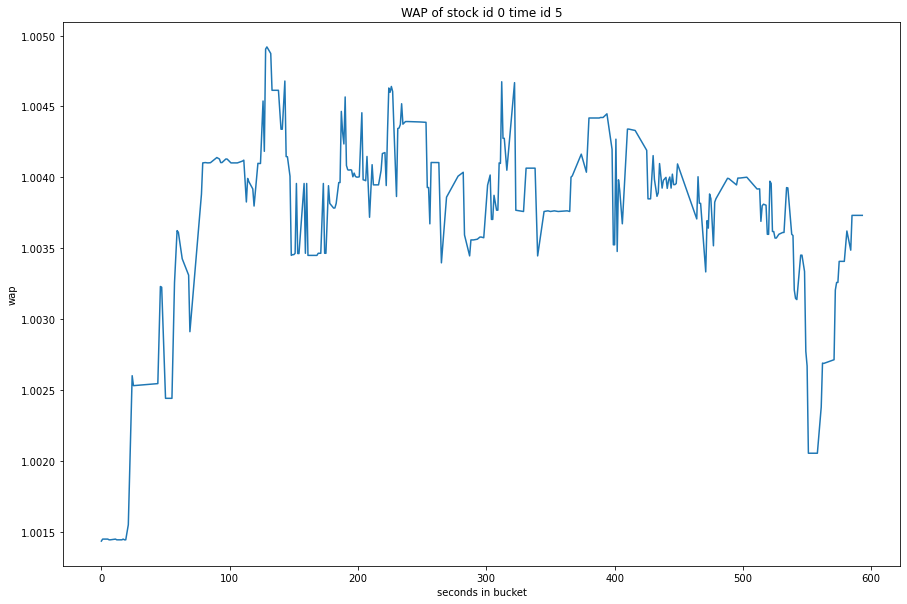

In [45]:
#fig = px.line(book_example, x="seconds_in_bucket", y="wap", title='WAP of stock_id_0, time_id_5')
#fig.show()
plt.figure(figsize=(15,10))
plt.plot(book_example['seconds_in_bucket'],book_example['wap'])
plt.xlabel('seconds in bucket')
plt.ylabel('wap')
plt.title('WAP of stock id 0 time id 5')
plt.show()

To compute the log return, we can simply take **the logarithm of the ratio** between two consecutive **WAP**. The first row will have an empty return as the previous book update is unknown, therefore the empty return data point will be dropped.

In [46]:
def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff() 

In [47]:
book_example.loc[:,'log_return'] = log_return(book_example['wap'])
book_example = book_example[~book_example['log_return'].isnull()]

**Let's plot the tick-to-tick return of this instrument over this time bucket**

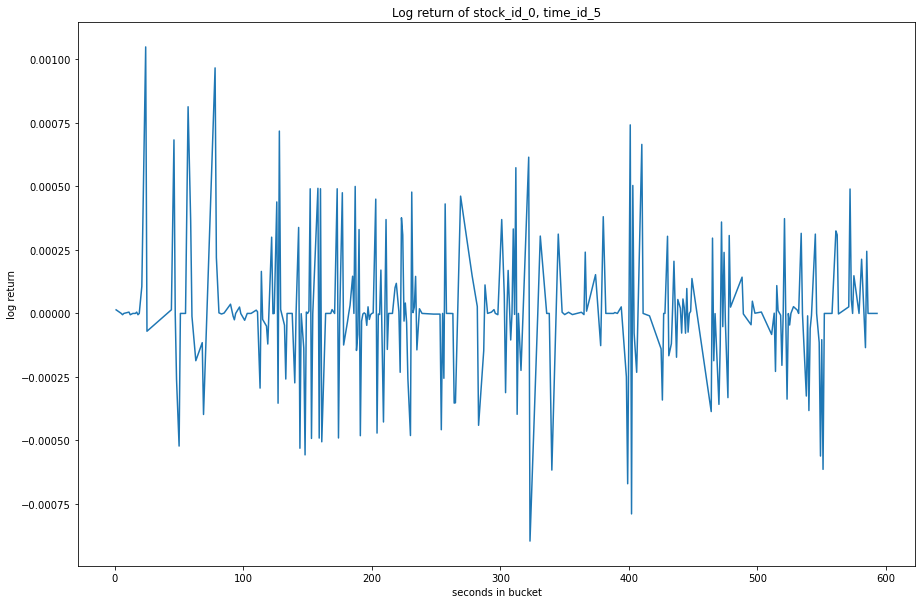

In [48]:
#fig = px.line(book_example, x="seconds_in_bucket", y="log_return", title='Log return of stock_id_0, time_id_5')
plt.figure(figsize=(15,10))
plt.plot(book_example['seconds_in_bucket'],book_example['log_return'])
plt.xlabel('seconds in bucket')
plt.ylabel('log return')
plt.title('Log return of stock_id_0, time_id_5')
plt.show()

The realized vol of stock 0 in this feature bucket, will be:

In [50]:
def realized_volatility(series_log_return):
    return np.sqrt(np.sum(series_log_return**2))
realized_vol = realized_volatility(book_example['log_return'])
print(f'Realized volatility for stock_id 0 on time_id 5 is {realized_vol}')

Realized volatility for stock_id 0 on time_id 5 is 0.004499364172786558


# Naive prediction: using past realized volatility as target

A commonly known fact about volatility is that it tends to be autocorrelated. We can use this property to implement a naive model that just "predicts" realized volatility by using whatever the realized volatility was in the initial 10 minutes.

Let's calculate the past realized volatility across the training set to see how predictive a single naive signal can be.

In [59]:
import os
from sklearn.metrics import r2_score
import glob
list_order_book_file_train = glob.glob(r'C:\Users\laurent\ownCloud\Data\Kaggle\optiver-realized-volatility-prediction\book_train.parquet\*')

As the data is partitioned by stock_id in this competition to allow Kagglers better manage the memory, we try to calculcate realized volatility stock by stock and combine them into one submission file. Note that the stock id as the partition column is not present if we load the single file so we will remedy that manually. We will reuse the log return and realized volatility functions defined in the previous session.

In [60]:
def realized_volatility_per_time_id(file_path, prediction_column_name):
    df_book_data = pd.read_parquet(file_path)
    df_book_data['wap'] =(df_book_data['bid_price1'] * df_book_data['ask_size1']+df_book_data['ask_price1'] * df_book_data['bid_size1'])  / (
                                      df_book_data['bid_size1']+ df_book_data[
                                  'ask_size1'])
    df_book_data['log_return'] = df_book_data.groupby(['time_id'])['wap'].apply(log_return)
    df_book_data = df_book_data[~df_book_data['log_return'].isnull()]
    df_realized_vol_per_stock =  pd.DataFrame(df_book_data.groupby(['time_id'])['log_return'].agg(realized_volatility)).reset_index()
    df_realized_vol_per_stock = df_realized_vol_per_stock.rename(columns = {'log_return':prediction_column_name})
    stock_id = file_path.split('=')[1]
    df_realized_vol_per_stock['row_id'] = df_realized_vol_per_stock['time_id'].apply(lambda x:f'{stock_id}-{x}')
    return df_realized_vol_per_stock[['row_id',prediction_column_name]]

Looping through each individual stocks, we can get the past realized volatility as prediction for each individual stocks.

In [61]:
def past_realized_volatility_per_stock(list_file,prediction_column_name):
    df_past_realized = pd.DataFrame()
    for file in list_file:
        df_past_realized = pd.concat([df_past_realized,
                                     realized_volatility_per_time_id(file,prediction_column_name)])
    return df_past_realized
df_past_realized_train = past_realized_volatility_per_stock(list_file=list_order_book_file_train,
                                                           prediction_column_name='pred')

In [79]:
#df_past_realized_train.to_csv('test_realized.csv')
df_past_realized_train.head(80)

,row_id,pred
0,0-5,0.004499
1,0-11,0.001204
2,0-16,0.002369
3,0-31,0.002574
4,0-62,0.001894
...,...,...
75,0-659,0.003682
76,0-675,0.006421
77,0-697,0.005327
78,0-709,0.009984


In [72]:
train

,row_id,target
0,0-5,0.004136
1,0-11,0.001445
2,0-16,0.002168
3,0-31,0.002195
4,0-62,0.001747
...,...,...
428927,126-32751,0.003461
428928,126-32753,0.003113
428929,126-32758,0.004070
428930,126-32763,0.003357


Let's join the output dataframe with train.csv to see the performance of the naive prediction on training set.

In [74]:
train['row_id'] = train['stock_id'].astype(str) + '-' + train['time_id'].astype(str)
train = train[['row_id','target']]
df_joined = train.merge(df_past_realized_train[['row_id','pred']], on = ['row_id'], how = 'left')

In [75]:
df_joined

,row_id,target,pred
0,0-5,0.004136,0.004499
1,0-11,0.001445,0.001204
2,0-16,0.002168,0.002369
3,0-31,0.002195,0.002574
4,0-62,0.001747,0.001894
...,...,...,...
428927,126-32751,0.003461,0.003691
428928,126-32753,0.003113,0.004104
428929,126-32758,0.004070,0.003118
428930,126-32763,0.003357,0.003661


We will evaluate the naive prediction result by two metrics: RMSPE and R squared. 

In [15]:
from sklearn.metrics import r2_score
def rmspe(y_true, y_pred):
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))
R2 = round(r2_score(y_true = df_joined['target'], y_pred = df_joined['pred']),3)
RMSPE = round(rmspe(y_true = df_joined['target'], y_pred = df_joined['pred']),3)
print(f'Performance of the naive prediction: R2 score: {R2}, RMSPE: {RMSPE}')

Performance of the naive prediction: R2 score: 0.628, RMSPE: 0.341


The performance of the naive model is not amazing but as a benchmark it is a reasonable start.

# Submission

As a last step, we will make a submission via the tutorial notebook -- through a file written to output folder.  The naive submission scored a RMSPE 0.327 on public LB, the room of improvement is big for sure!

In [16]:
list_order_book_file_test = glob.glob('/kaggle/input/optiver-realized-volatility-prediction/book_test.parquet/*')
df_naive_pred_test = past_realized_volatility_per_stock(list_file=list_order_book_file_test,
                                                           prediction_column_name='target')
df_naive_pred_test.to_csv('submission.csv',index = False)

Note that in this competition, there will be only few rows of test data that can be downloaded. The actual evaluation program will run in background after you commit the notebook and manually submit the output. Please check to [code requirement](https://www.kaggle.com/c/optiver-realized-volatility-prediction/overview/code-requirements) for more explanation.

The private leaderboard will be built against the real market data collected after the training period, therefore the public and private leaderboard data will have zero overlap. It will be exciting to get your model tested against the live market! As this competition will provide a very rich dataset representing market microstructure, there is unlimited amount of signals one can come up with. It is all on you, good luck! We at Optiver are really looking forward to learn from the talented Kaggle community!

If you have any question about this notebook or the financial concepts behind it, feel free to ask in the comment section and we will make sure your questions get answered. 

Good luck!